### <img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393/578 Máquinas de Aprendizaje - 2019-1 </h1>

<H3 align='center'> Tarea 3 - Parte3  </H3>
<hr style="height:2px;border:none"/>

**Integrantes**  
* Rodrigo Hermosilla
* Eliana Providel
* Sebastián Rodriguez

<a id="tercero"></a>
## 3. Clasificación en texto

Un problema muy complejo, en el cual actualmente se esta avanzando a pasos de gigantes en comparación con los avances de hace unos cuantos años, es en la comprehensión de texto, o de lenguaje natural en general. Nuestra manera de construir significado a partir de las palabras es mucho más compleja de lo que nos damos cuenta y supone un gran grado de conocimiento previo que hemos adquirido a lo largo de nuestras vidas. Lograr que una maquina de aprendizaje pueda extraer significado o interpretaciones a partir de un texto es un problema bastante actual, en el cual aún se hacen avances día a día. En esta pregunta utilizaremos una base de datos de texto, extraida de _reviews_ de peliculas en la página IMDB. Cada uno de estos _reviews_ esta etiquetado como positivo o negativo. Nuestra tarea será predecir esta etiqueta a partir de la secuencia de palabras encodeadas como frecuencias de cada ejemplo.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/6a/New-imdb-logo.png/1024px-New-imdb-logo.png"  style="height:6cm;"  />

Para esto probaremos distintas técnicas, incluyendo Perceptron, Redes densas _feed forward_ y ensamblados. Si bien ninguna de estas aproximaciones son las usualmente utilizadas en la actualidad para procesamiento de texto (_words embeddings_, redes recurrentes y redes convolucionales, entre muchos otros), esta pregunta servirá como una buena aproximación a las problematicas usualmente encontradas en estas técnicas y al momento de trabajar con texto. 


#### 3.a Carga de datos

> Cargue los datos. Utilizaremos 45000 de los datos como entrenamiento y el resto como validación. Guarde los datos originales luego del _padding_ en un _array_ que utilizaremos más adelante, y cree otro _array_ 2-dimensional con los datos como categorías binarias como muestran las últimas lineas de código.

> Lea un poco de la documentación de keras y comente sobre los parámetros utilizados al momento de cargar los datos. ¿Qué realiza la función `pad_sequences`? Comente también sobre sus parámetros.


In [1]:
import numpy as np
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.callbacks import LambdaCallback
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import  confusion_matrix, classification_report
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
%matplotlib inline

/home/srodriguez/miniconda/envs/jupyterhub/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
num_words=100
(x_tr_o, y_tr), (x_val_o, y_val) = imdb.load_data(num_words=num_words,
                                             skip_top=10,
                                             oov_char=0,
                                             )

In [3]:
#mostramos largos de secuencias originales
_=[print(len(x_tr_o[i])) for i in range(10)]

218
189
141
550
147
43
123
562
233
130


> Paso de los datos a largos estandarizados de 100 elementos

El pad_sequences rellena de 0 los elementos, para dejarlos todos de un mismo largo.

Parámetros:
- El primero (data) es la secuencia o sobre la cual se aplicará el padding.
- El segundo (maxlen), indica el tamaño maximo de la secuencia de salida.
- El tercero (padding), indica que el padding (llenado) se hará al final de la secuencia.
- El cuarto (truncating), indica donde se hará el corte para secuencias de origen de largo mayor al maxlen definido.
- El quinto (value), el valor que se agregará en el padding.

In [4]:
x_tr_o = pad_sequences(x_tr_o, maxlen=100, padding='post', truncating='post',value=0)
x_val_o = pad_sequences(x_val_o, maxlen=100, padding='post', truncating='post',value=0)

In [5]:
#verificamos los nuevos largos de secuencia
_=[print(len(x_tr_o[i])) for i in range(10)]

100
100
100
100
100
100
100
100
100
100


In [6]:
print(len(x_tr_o))
print(len(x_val_o))

25000
25000


In [7]:
#resize de los set de datos
x_tr_o = np.append(x_tr_o, x_val_o[:20000,],axis=0)
y_tr = np.append(y_tr, y_val[:20000,],axis=0)
x_val_o=x_val_o[20000:]
y_val=y_val[20000:]

In [8]:
print(len(x_tr_o))
print(len(x_val_o))

45000
5000


In [9]:
np.unique(x_tr_o)

array([ 0, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
       26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
       43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
       60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76,
       77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93,
       94, 95, 96, 97, 98, 99], dtype=int32)

In [10]:
from sklearn.feature_extraction.text import CountVectorizer


In [11]:
new_x_tr = np.array([" ".join(arr.astype("str")) for arr in x_tr_o])
new_x_val = np.array([" ".join(arr.astype("str")) for arr in x_val_o])

new_x_tr

array(['0 14 22 16 43 0 0 0 0 65 0 0 66 0 0 0 36 0 0 25 0 43 0 0 50 0 0 0 35 0 0 0 0 0 0 0 0 0 0 0 39 0 0 0 0 17 0 38 13 0 0 0 50 16 0 0 0 19 14 22 0 0 0 0 0 22 71 87 12 16 43 0 38 76 15 13 0 0 22 17 0 17 12 16 0 18 0 0 62 0 12 0 0 0 0 0 0 0 0 16',
       '0 0 0 0 0 78 0 0 0 0 0 0 0 26 0 0 0 0 0 14 0 20 13 0 0 0 0 0 0 0 0 21 14 69 0 0 30 23 0 0 0 0 93 0 0 0 0 0 0 0 0 0 0 35 0 0 0 0 0 0 0 0 0 0 0 0 19 0 0 0 89 29 0 46 37 0 0 0 45 43 38 0 0 0 0 0 26 0 0 0 11 0 0 0 0 0 0 0 0 0',
       '0 14 47 0 30 31 0 0 0 0 0 0 0 54 61 0 13 71 0 14 22 0 0 0 0 12 16 0 33 75 43 0 0 0 86 0 35 0 19 0 0 0 0 0 33 89 78 12 66 16 0 0 0 0 58 0 0 11 0 0 43 0 0 0 0 85 0 42 0 0 83 68 0 15 36 0 0 0 36 69 0 0 0 0 14 0 0 18 0 22 12 0 28 0 40 0 87 0 23 0',
       ...,
       '0 0 0 0 13 81 0 0 0 0 0 0 0 0 0 0 0 88 0 0 0 0 0 89 0 12 32 16 0 0 0 0 0 0 0 0 19 0 0 0 0 0 0 0 0 0 52 0 0 0 0 73 0 46 0 50 0 49 87 0 0 0 0 0 16 0 19 0 0 0 0 0 17 0 0 0 0 0 0 0 0 0 0 11 0 0 0 0 11 0 61 64 0 71 49 0 0 11 31 42',
       '0 14 0 31 

In [12]:
cv = CountVectorizer(token_pattern=r"\b\d+\b")

new_x_tr_vec = cv.fit_transform(new_x_tr)

In [13]:
new_x_val_vec = cv.transform(new_x_val)

In [14]:
new_x_val_vec[0].todense()

matrix([[70,  0,  2,  0,  1,  2,  1,  0,  1,  1,  3,  2,  0,  1,  0,  0,
          0,  1,  0,  1,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  3,
          0,  1,  0,  0,  0,  1,  0,  0,  1,  0,  0,  0,  0,  2,  0,  1,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  1,  1,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [15]:
x_tr = to_categorical(x_tr_o, num_classes=101).reshape(x_tr_o.shape[0],-1)
x_val = to_categorical(x_val_o, num_classes=101).reshape(x_val_o.shape[0],-1)

In [16]:
print(x_tr_o[0])
print(x_tr[0][:100])
print(x_tr[0][100:200])
print(x_tr[0][200:300])
print(x_tr[0][300:400])

[ 0 14 22 16 43  0  0  0  0 65  0  0 66  0  0  0 36  0  0 25  0 43  0  0
 50  0  0  0 35  0  0  0  0  0  0  0  0  0  0  0 39  0  0  0  0 17  0 38
 13  0  0  0 50 16  0  0  0 19 14 22  0  0  0  0  0 22 71 87 12 16 43  0
 38 76 15 13  0  0 22 17  0 17 12 16  0 18  0  0 62  0 12  0  0  0  0  0
  0  0  0 16]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0.

In [17]:
from keras import backend as K
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

#### 3.b Perceptrón **(Opcional)**
> Entrene un perceptrón con activación sigmoidea, optimizador _Stochastic Gradient Descent_, por a lo menos 15 _epochs_, como muestra el código siguiente. 

> Discuta sobre la dimensión de `x_tr` y la cantidad de parámetros del modelo deacuerdo al método `.summary` del modelo. 

> Grafique el error o el _accuracy_ segun su preferencia, tanto sobre entrenamiento como validación, a medida pasan los _epochs_. Note esta información puede obtenerla desde `history.history`.

In [18]:
model3b = Sequential()
model3b.add(Dense(1,activation='sigmoid'))
model3b.compile('sgd',loss='binary_crossentropy',metrics=['accuracy'])
history3b = model3b.fit(new_x_tr_vec.todense(),y_tr, epochs=15, validation_data=(new_x_val_vec.todense(),y_val))
model3b.summary()

Train on 45000 samples, validate on 5000 samples
Epoch 1/15
45000/45000 [==============================] - 7s 153us/step - loss: 7.4646 - acc: 0.4997 - val_loss: 8.2297 - val_acc: 0.4894
Epoch 2/15
45000/45000 [==============================] - 7s 158us/step - loss: 7.5785 - acc: 0.5018 - val_loss: 8.2278 - val_acc: 0.4894
Epoch 3/15
45000/45000 [==============================] - 6s 144us/step - loss: 7.4056 - acc: 0.5029 - val_loss: 8.2290 - val_acc: 0.4894
Epoch 4/15
45000/45000 [==============================] - 6s 143us/step - loss: 4.6523 - acc: 0.5167 - val_loss: 2.0094 - val_acc: 0.5718
Epoch 5/15
45000/45000 [==============================] - 7s 150us/step - loss: 4.0966 - acc: 0.5291 - val_loss: 3.8497 - val_acc: 0.5404
Epoch 6/15
45000/45000 [==============================] - 7s 148us/step - loss: 3.9892 - acc: 0.5431 - val_loss: 2.4228 - val_acc: 0.5854
Epoch 7/15
45000/45000 [==============================] - 6s 144us/step - loss: 3.8089 - acc: 0.5429 - val_loss: 2.4097 - v

In [19]:
def plotCM(y_val, y_pred, title):
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(15,6))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix: '+title) 
    _=plt.show()

In [20]:
#FALTA AGREGAR NOMBRES DE EJES

def showValAcc(history):
    fig=plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.set_title('loss vs val_loss')
    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'], label='validation loss')
    ax1.legend()
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.set_title('acc vs val_acc')
    ax2.plot(history.history['acc'], label='accuracy')
    ax2.plot(history.history['val_acc'], label='validation accuracy')
    ax2.legend()
    _=plt.show()

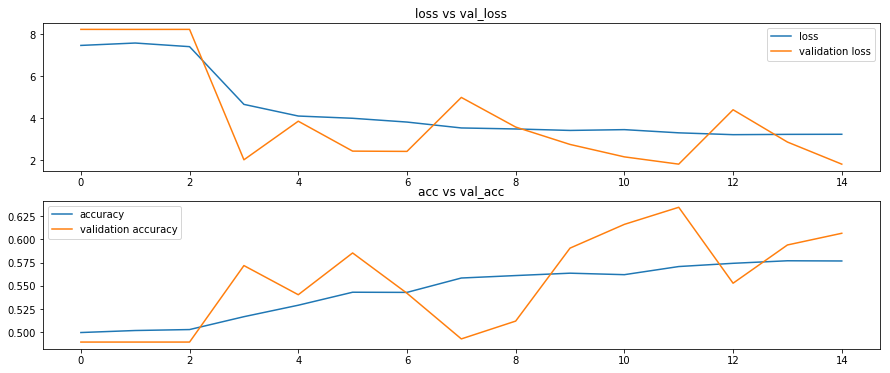

In [21]:
showValAcc(history3b)

Comentarios: podemos observar que es mejor que "tirar una moneda", pero nuestro modelo se ajusta demasiado a los datos de entrenamiento

#### 3.c Red con una capa oculta
Ahora, haremos nuevamente un modelo secuencial, al cual le agregarémos una capa oculta con activación ReLu. ¿Qué realiza la función ReLu (puede ejemplificar con gráficos)?

Entrene esta red nuevamente con los mismos parámetros que la red anterior. ¿Mejoran los desempeños? ¿Cuál es el número de parámetros de este modelo? Grafíque nuevamente como varía la métrica a medida pasan las _epochs_. ¿Alcanza a notar sobreajuste?

Cambie la función de activación por otra de su elección (e.g. $tanh$ o activación lineal). ¿Cambia el desempeño? 

Compare finalmente el desempeño con una regresión lineal. ¿Cómo hace la red para obtener representaciones no-lineales que la regresión lineal no puede obtener? ¿Por qué se podría argumentar que una red neuronal densa _feed forward_ tiene un sabor a ensamblado de regresiones lineales en un principio? 

In [22]:
model3c_relu = Sequential()
model3c_relu.add(Dense(32, activation='relu', input_dim=new_x_tr_vec.shape[1]))
model3c_relu.add(Dense(1,activation='sigmoid'))
model3c_relu.compile('sgd',loss='binary_crossentropy',metrics=['accuracy'])
history3c_relu = model3c_relu.fit(new_x_tr_vec.todense(),y_tr, epochs=15, validation_data=(new_x_val_vec.todense(),y_val))
model3c_relu.summary()

Train on 45000 samples, validate on 5000 samples
Epoch 1/15
45000/45000 [==============================] - 7s 152us/step - loss: 0.7106 - acc: 0.5506 - val_loss: 0.6768 - val_acc: 0.5668
Epoch 2/15
45000/45000 [==============================] - 7s 158us/step - loss: 0.6754 - acc: 0.5772 - val_loss: 0.7370 - val_acc: 0.4942
Epoch 3/15
45000/45000 [==============================] - 7s 149us/step - loss: 0.6671 - acc: 0.5897 - val_loss: 0.6611 - val_acc: 0.6032
Epoch 4/15
45000/45000 [==============================] - 7s 154us/step - loss: 0.6603 - acc: 0.6024 - val_loss: 0.6936 - val_acc: 0.5324
Epoch 5/15
45000/45000 [==============================] - 7s 161us/step - loss: 0.6544 - acc: 0.6095 - val_loss: 0.6562 - val_acc: 0.6100
Epoch 6/15
45000/45000 [==============================] - 7s 149us/step - loss: 0.6511 - acc: 0.6142 - val_loss: 0.6611 - val_acc: 0.5848
Epoch 7/15
45000/45000 [==============================] - 7s 149us/step - loss: 0.6454 - acc: 0.6227 - val_loss: 0.6263 - v

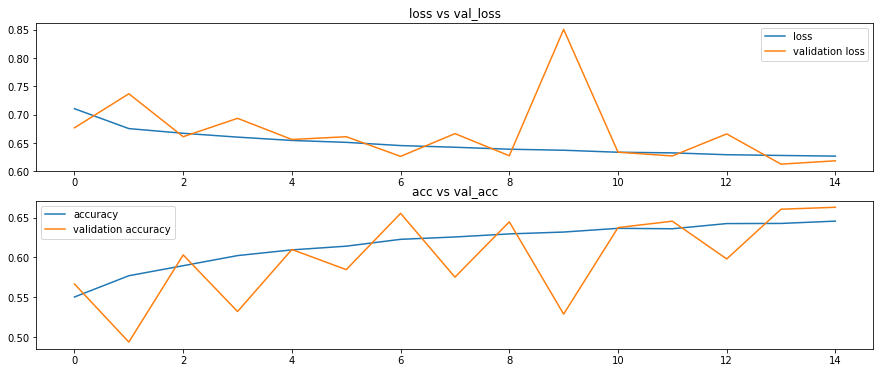

In [23]:
showValAcc(history3c_relu)

In [24]:
model3c_tanh = Sequential()
model3c_tanh.add(Dense(32, activation='tanh', input_dim=new_x_tr_vec.shape[1]))
model3c_tanh.add(Dense(1,activation='sigmoid'))
model3c_tanh.compile('sgd',loss='binary_crossentropy',metrics=['accuracy'])
history3c_tanh = model3c_tanh.fit(new_x_tr_vec.todense(),y_tr, epochs=15, validation_data=(new_x_val_vec.todense(),y_val))
model3c_tanh.summary()

Train on 45000 samples, validate on 5000 samples
Epoch 1/15
45000/45000 [==============================] - 8s 167us/step - loss: 0.6910 - acc: 0.5310 - val_loss: 0.7034 - val_acc: 0.4916
Epoch 2/15
45000/45000 [==============================] - 7s 155us/step - loss: 0.6833 - acc: 0.5535 - val_loss: 0.6780 - val_acc: 0.5768
Epoch 3/15
45000/45000 [==============================] - 7s 154us/step - loss: 0.6758 - acc: 0.5753 - val_loss: 0.6723 - val_acc: 0.5892
Epoch 4/15
45000/45000 [==============================] - 7s 163us/step - loss: 0.6700 - acc: 0.5878 - val_loss: 0.7139 - val_acc: 0.5344
Epoch 5/15
45000/45000 [==============================] - 7s 151us/step - loss: 0.6660 - acc: 0.5939 - val_loss: 0.6468 - val_acc: 0.6308
Epoch 6/15
45000/45000 [==============================] - 7s 153us/step - loss: 0.6605 - acc: 0.6031 - val_loss: 0.6705 - val_acc: 0.5904
Epoch 7/15
45000/45000 [==============================] - 7s 162us/step - loss: 0.6578 - acc: 0.6085 - val_loss: 0.6702 - v

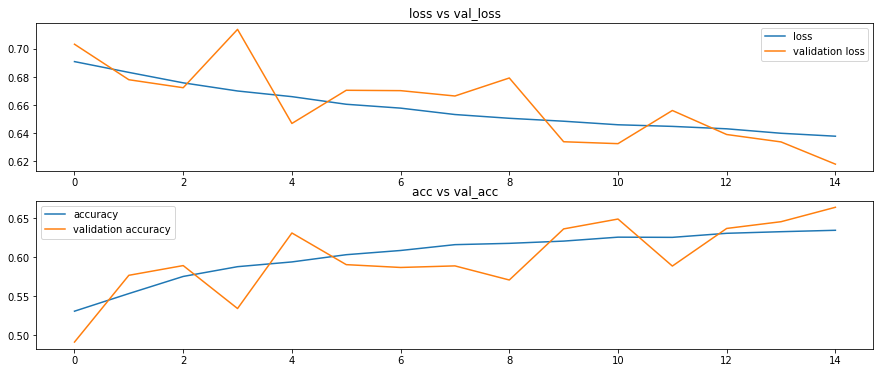

In [25]:
showValAcc(history3c_tanh)

In [26]:
model3c_linear = Sequential()
model3c_linear.add(Dense(32, activation='linear', input_dim=new_x_tr_vec.shape[1]))
model3c_linear.add(Dense(1,activation='sigmoid'))
model3c_linear.compile('sgd',loss='binary_crossentropy',metrics=['accuracy'])
history3c_linear =model3c_linear.fit(new_x_tr_vec.todense(),y_tr, epochs=15, validation_data=(new_x_val_vec.todense(),y_val))
model3c_linear.summary()

Train on 45000 samples, validate on 5000 samples
Epoch 1/15
45000/45000 [==============================] - 7s 160us/step - loss: 7.9969 - acc: 0.4983 - val_loss: 7.8022 - val_acc: 0.5106
Epoch 2/15
45000/45000 [==============================] - 7s 166us/step - loss: 7.9900 - acc: 0.4988 - val_loss: 7.8022 - val_acc: 0.5106
Epoch 3/15
45000/45000 [==============================] - 9s 195us/step - loss: 7.9900 - acc: 0.4988 - val_loss: 7.8022 - val_acc: 0.5106
Epoch 4/15
45000/45000 [==============================] - 8s 188us/step - loss: 7.9900 - acc: 0.4988 - val_loss: 7.8022 - val_acc: 0.5106
Epoch 5/15
45000/45000 [==============================] - 9s 203us/step - loss: 7.9900 - acc: 0.4988 - val_loss: 7.8022 - val_acc: 0.5106
Epoch 6/15
45000/45000 [==============================] - 9s 193us/step - loss: 7.9900 - acc: 0.4988 - val_loss: 7.8022 - val_acc: 0.5106
Epoch 7/15
45000/45000 [==============================] - 10s 216us/step - loss: 7.9900 - acc: 0.4988 - val_loss: 7.8022 - 

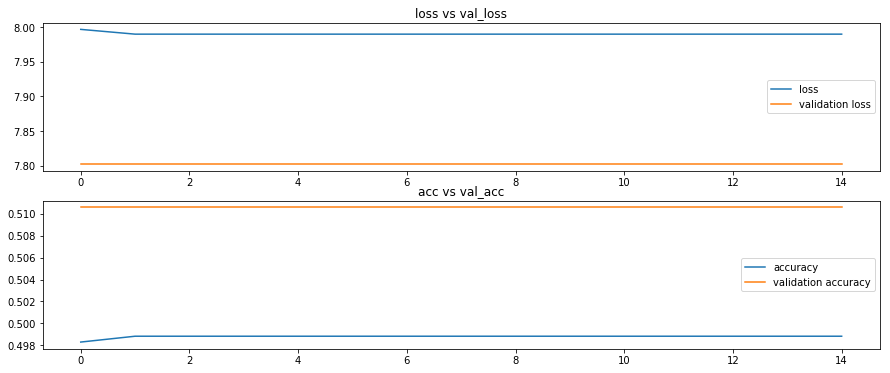

In [27]:
showValAcc(history3c_linear)

In [28]:
reg=LinearRegression()

In [29]:
reg.fit(new_x_tr_vec, y_tr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

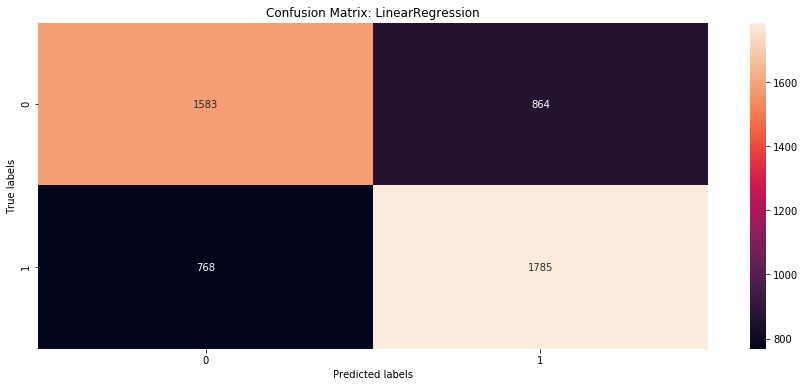

              precision    recall  f1-score   support

           0       0.67      0.65      0.66      2447
           1       0.67      0.70      0.69      2553

    accuracy                           0.67      5000
   macro avg       0.67      0.67      0.67      5000
weighted avg       0.67      0.67      0.67      5000



In [30]:
y_pred=reg.predict(new_x_val_vec)
y_pred_binary = np.where(y_pred>0.5, 1,0)
plotCM(y_val, y_pred_binary, 'LinearRegression')
print(classification_report(y_val, y_pred_binary))

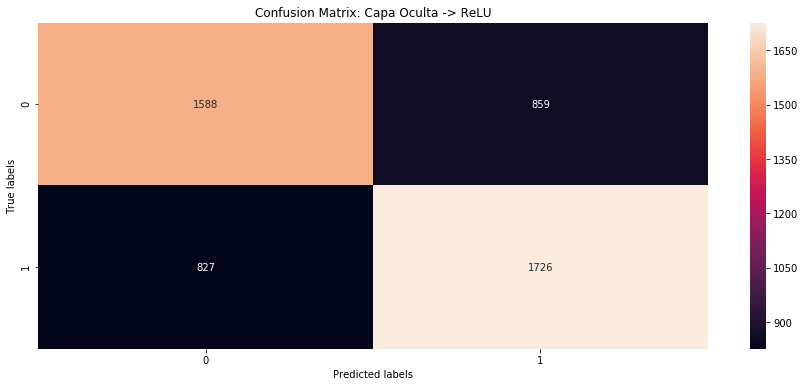

              precision    recall  f1-score   support

           0       0.66      0.65      0.65      2447
           1       0.67      0.68      0.67      2553

    accuracy                           0.66      5000
   macro avg       0.66      0.66      0.66      5000
weighted avg       0.66      0.66      0.66      5000



In [31]:
y_pred=model3c_relu.predict(new_x_val_vec)
y_pred_binary = np.where(y_pred>0.5, 1,0)
plotCM(y_val, y_pred_binary, 'Capa Oculta -> ReLU')
print(classification_report(y_val, y_pred_binary))

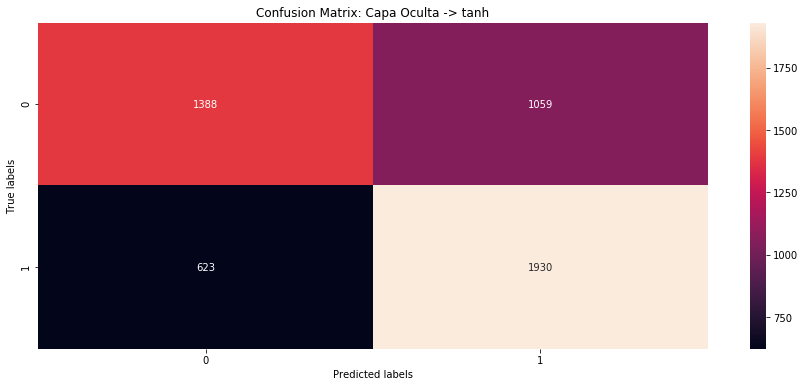

              precision    recall  f1-score   support

           0       0.69      0.57      0.62      2447
           1       0.65      0.76      0.70      2553

    accuracy                           0.66      5000
   macro avg       0.67      0.66      0.66      5000
weighted avg       0.67      0.66      0.66      5000



In [32]:
y_pred=model3c_tanh.predict(new_x_val_vec)
y_pred_binary = np.where(y_pred>0.5, 1,0)
plotCM(y_val, y_pred_binary, 'Capa Oculta -> tanh')
print(classification_report(y_val, y_pred_binary))

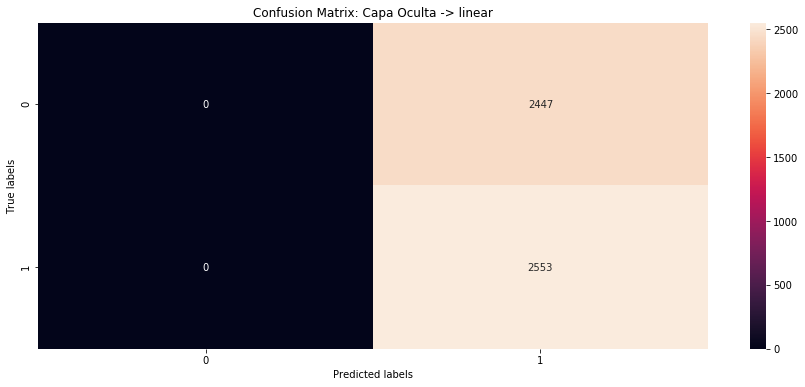

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2447
           1       0.51      1.00      0.68      2553

    accuracy                           0.51      5000
   macro avg       0.26      0.50      0.34      5000
weighted avg       0.26      0.51      0.35      5000



/home/srodriguez/miniconda/envs/jupyterhub/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/srodriguez/miniconda/envs/jupyterhub/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/srodriguez/miniconda/envs/jupyterhub/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [33]:
y_pred=model3c_linear.predict(new_x_val_vec)
y_pred_binary = np.where(y_pred>0.5, 1,0)
plotCM(y_val, y_pred_binary, 'Capa Oculta -> linear')
print(classification_report(y_val, y_pred_binary))

#### 3.d Exploración de número de neuronas ocultas

Utilizando la misma estructura de la red entrenada en la pregunta anterior, evalue como varía el _accuracy_ sobre validación y entrenamiento a medida se cambia el numero de neuronas. Explore numeros de neuronas en potencias de 2 entre 2 y 256. En cada iteración debe considerar el mejor _accuracy_ sobre validación y el _accuracy_ de entrenamiento de ese mísmo _epoch_, pues ese sería el modelo que se preferiría. 

Grafique como variaron los _accuracy_ a medida cambió el número de neuronas y discuta. 

Red con 2 unidades
Train on 45000 samples, validate on 5000 samples
Epoch 1/15
45000/45000 [==============================] - 9s 198us/step - loss: 0.6931 - acc: 0.5052 - val_loss: 0.6931 - val_acc: 0.5138
Epoch 2/15
45000/45000 [==============================] - 9s 196us/step - loss: 0.6926 - acc: 0.5181 - val_loss: 0.6929 - val_acc: 0.5186
Epoch 3/15
45000/45000 [==============================] - 9s 197us/step - loss: 0.6914 - acc: 0.5344 - val_loss: 0.6918 - val_acc: 0.5260
Epoch 4/15
45000/45000 [==============================] - 11s 242us/step - loss: 0.6879 - acc: 0.5501 - val_loss: 0.6892 - val_acc: 0.5358
Epoch 5/15
45000/45000 [==============================] - 9s 192us/step - loss: 0.6805 - acc: 0.5670 - val_loss: 0.6819 - val_acc: 0.5698
Epoch 6/15
45000/45000 [==============================] - 8s 189us/step - loss: 0.6708 - acc: 0.5909 - val_loss: 0.6786 - val_acc: 0.5660
Epoch 7/15
45000/45000 [==============================] - 8s 189us/step - loss: 0.6599 - acc: 0.6146 - 

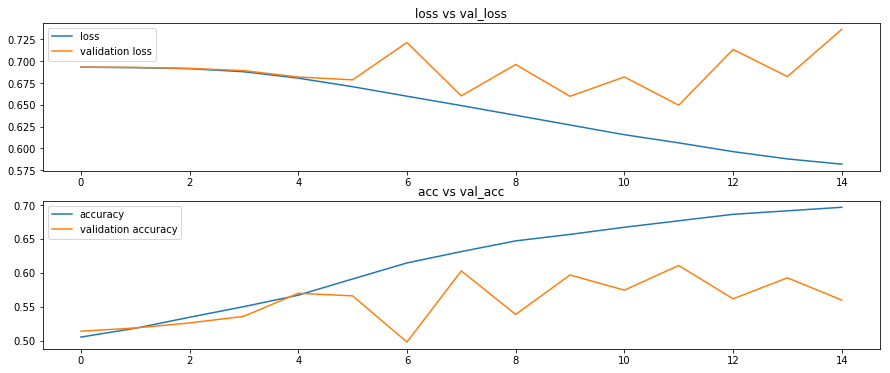

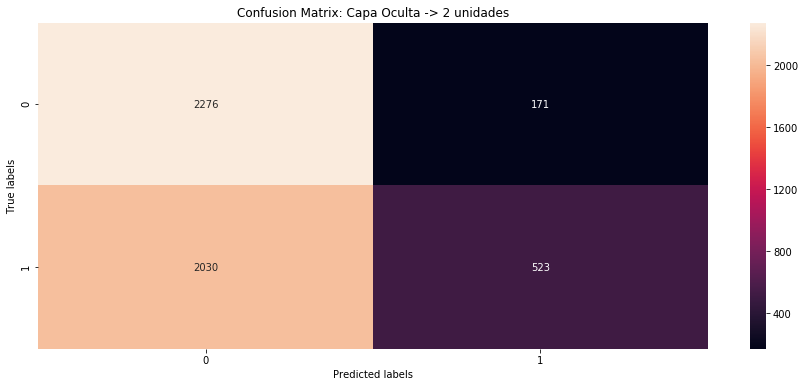

              precision    recall  f1-score   support

           0       0.53      0.93      0.67      2447
           1       0.75      0.20      0.32      2553

    accuracy                           0.56      5000
   macro avg       0.64      0.57      0.50      5000
weighted avg       0.64      0.56      0.49      5000

Red con 4 unidades
Train on 45000 samples, validate on 5000 samples
Epoch 1/15
45000/45000 [==============================] - 8s 186us/step - loss: 0.6930 - acc: 0.5079 - val_loss: 0.6929 - val_acc: 0.5070
Epoch 2/15
45000/45000 [==============================] - 9s 191us/step - loss: 0.6914 - acc: 0.5251 - val_loss: 0.6941 - val_acc: 0.5068
Epoch 3/15
45000/45000 [==============================] - 8s 186us/step - loss: 0.6871 - acc: 0.5478 - val_loss: 0.6879 - val_acc: 0.5464
Epoch 4/15
45000/45000 [==============================] - 9s 193us/step - loss: 0.6803 - acc: 0.5744 - val_loss: 0.6818 - val_acc: 0.5752
Epoch 5/15
45000/45000 [=============================

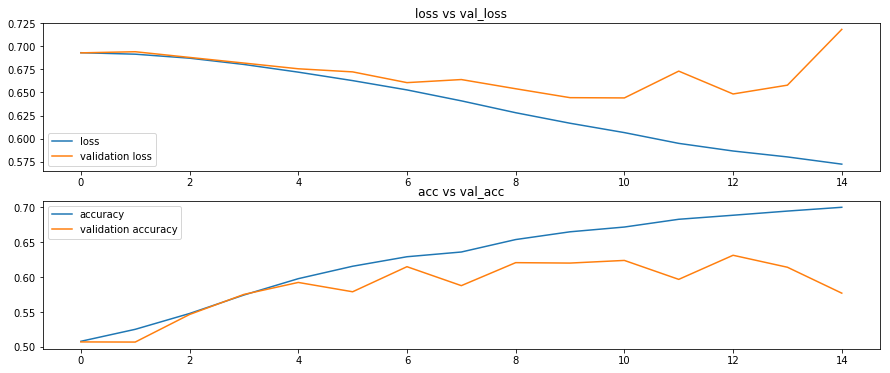

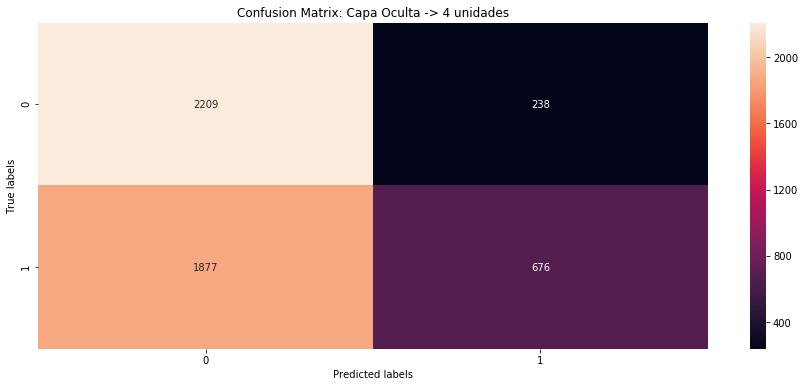

              precision    recall  f1-score   support

           0       0.54      0.90      0.68      2447
           1       0.74      0.26      0.39      2553

    accuracy                           0.58      5000
   macro avg       0.64      0.58      0.53      5000
weighted avg       0.64      0.58      0.53      5000

Red con 8 unidades
Train on 45000 samples, validate on 5000 samples
Epoch 1/15
45000/45000 [==============================] - 9s 192us/step - loss: 0.6924 - acc: 0.5154 - val_loss: 0.6915 - val_acc: 0.5176
Epoch 2/15
45000/45000 [==============================] - 8s 186us/step - loss: 0.6895 - acc: 0.5403 - val_loss: 0.6891 - val_acc: 0.5440
Epoch 3/15
45000/45000 [==============================] - 9s 192us/step - loss: 0.6845 - acc: 0.5636 - val_loss: 0.6918 - val_acc: 0.5144
Epoch 4/15
45000/45000 [==============================] - 8s 181us/step - loss: 0.6779 - acc: 0.5813 - val_loss: 0.6804 - val_acc: 0.5734
Epoch 5/15
45000/45000 [=============================

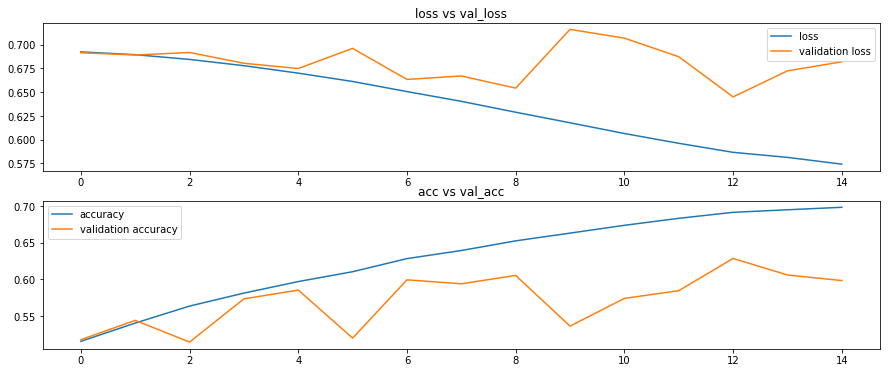

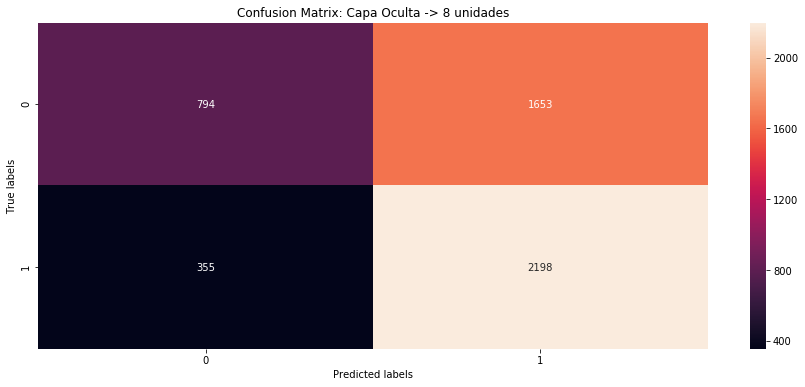

              precision    recall  f1-score   support

           0       0.69      0.32      0.44      2447
           1       0.57      0.86      0.69      2553

    accuracy                           0.60      5000
   macro avg       0.63      0.59      0.56      5000
weighted avg       0.63      0.60      0.57      5000

Red con 16 unidades
Train on 45000 samples, validate on 5000 samples
Epoch 1/15
45000/45000 [==============================] - 9s 190us/step - loss: 0.6920 - acc: 0.5208 - val_loss: 0.6924 - val_acc: 0.5156
Epoch 2/15
45000/45000 [==============================] - 9s 193us/step - loss: 0.6855 - acc: 0.5571 - val_loss: 0.6899 - val_acc: 0.5346
Epoch 3/15
45000/45000 [==============================] - 8s 183us/step - loss: 0.6766 - acc: 0.5778 - val_loss: 0.6922 - val_acc: 0.5314
Epoch 4/15
45000/45000 [==============================] - 8s 188us/step - loss: 0.6659 - acc: 0.6007 - val_loss: 0.6713 - val_acc: 0.5902
Epoch 5/15
45000/45000 [============================

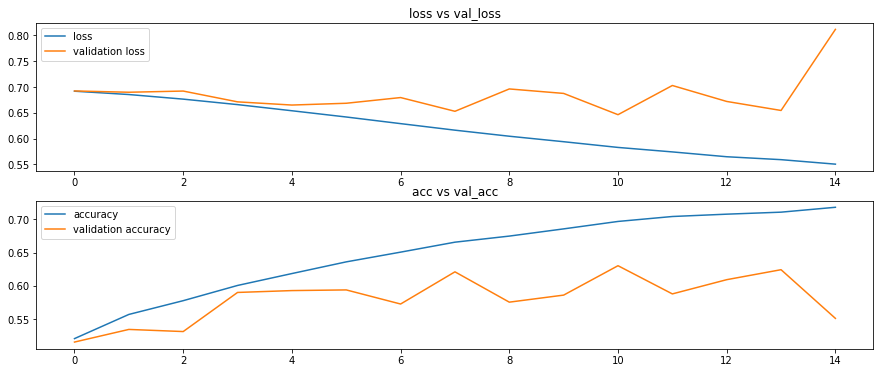

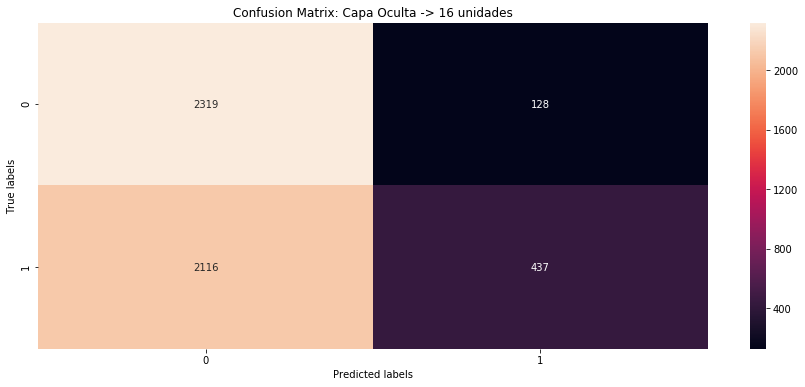

              precision    recall  f1-score   support

           0       0.52      0.95      0.67      2447
           1       0.77      0.17      0.28      2553

    accuracy                           0.55      5000
   macro avg       0.65      0.56      0.48      5000
weighted avg       0.65      0.55      0.47      5000

Red con 32 unidades
Train on 45000 samples, validate on 5000 samples
Epoch 1/15
45000/45000 [==============================] - 10s 219us/step - loss: 0.6910 - acc: 0.5267 - val_loss: 0.6901 - val_acc: 0.5336
Epoch 2/15
45000/45000 [==============================] - 11s 236us/step - loss: 0.6833 - acc: 0.5613 - val_loss: 0.6848 - val_acc: 0.5628
Epoch 3/15
45000/45000 [==============================] - 12s 256us/step - loss: 0.6749 - acc: 0.5845 - val_loss: 0.6787 - val_acc: 0.5794
Epoch 4/15
45000/45000 [==============================] - 11s 236us/step - loss: 0.6653 - acc: 0.6059 - val_loss: 0.6714 - val_acc: 0.5924
Epoch 5/15
45000/45000 [========================

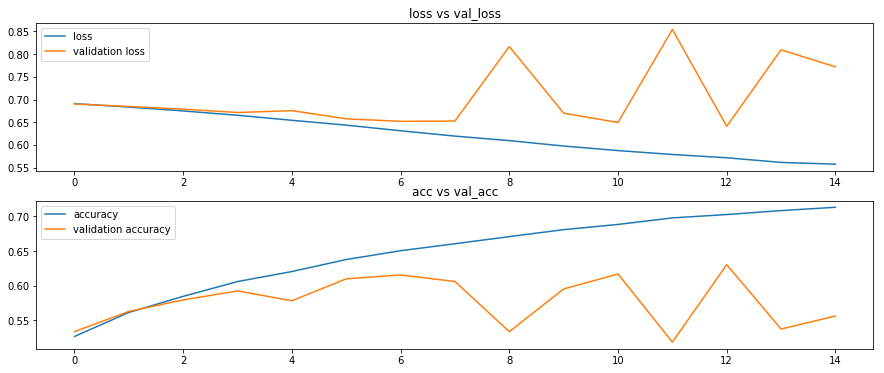

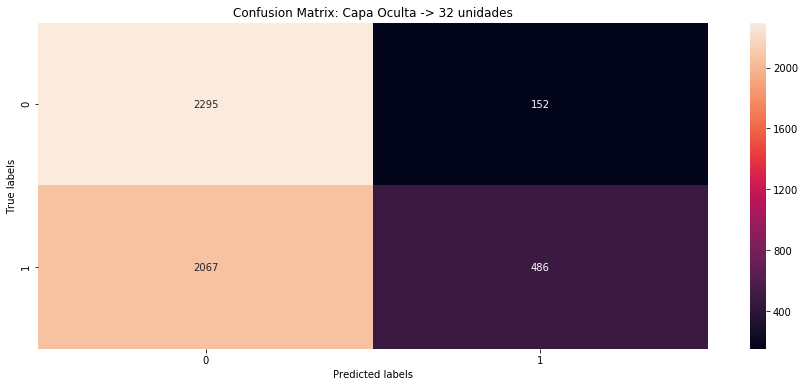

              precision    recall  f1-score   support

           0       0.53      0.94      0.67      2447
           1       0.76      0.19      0.30      2553

    accuracy                           0.56      5000
   macro avg       0.64      0.56      0.49      5000
weighted avg       0.65      0.56      0.49      5000

Red con 64 unidades
Train on 45000 samples, validate on 5000 samples
Epoch 1/15
45000/45000 [==============================] - 9s 195us/step - loss: 0.6912 - acc: 0.5244 - val_loss: 0.6880 - val_acc: 0.5496
Epoch 2/15
45000/45000 [==============================] - 8s 182us/step - loss: 0.6835 - acc: 0.5622 - val_loss: 0.6850 - val_acc: 0.5506
Epoch 3/15
45000/45000 [==============================] - 9s 195us/step - loss: 0.6757 - acc: 0.5855 - val_loss: 0.6784 - val_acc: 0.5798
Epoch 4/15
45000/45000 [==============================] - 8s 184us/step - loss: 0.6666 - acc: 0.6026 - val_loss: 0.6722 - val_acc: 0.5912
Epoch 5/15
45000/45000 [============================

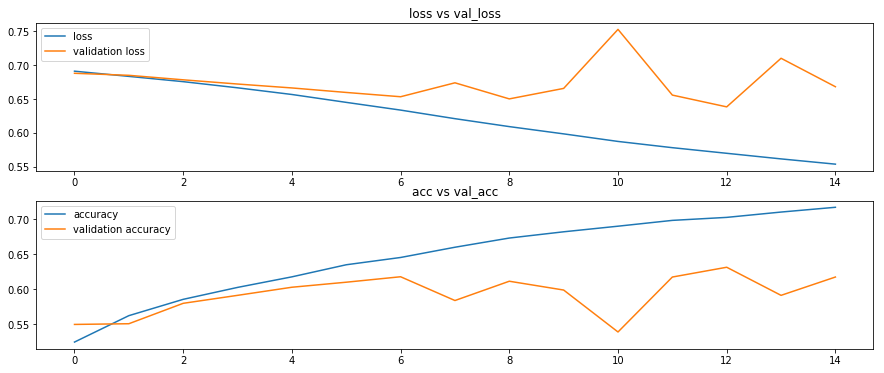

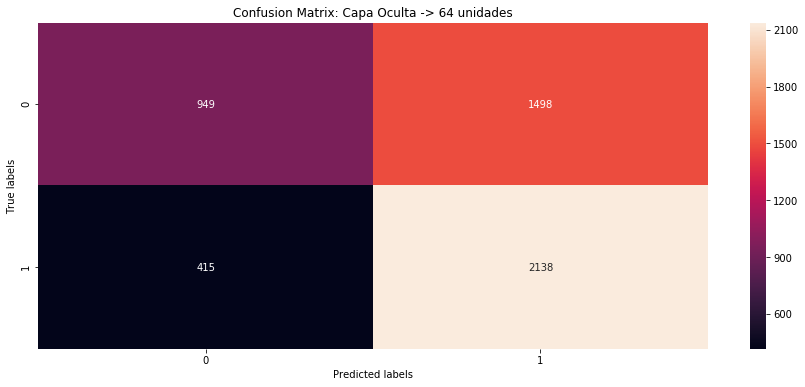

              precision    recall  f1-score   support

           0       0.70      0.39      0.50      2447
           1       0.59      0.84      0.69      2553

    accuracy                           0.62      5000
   macro avg       0.64      0.61      0.59      5000
weighted avg       0.64      0.62      0.60      5000

Red con 128 unidades
Train on 45000 samples, validate on 5000 samples
Epoch 1/15
45000/45000 [==============================] - 9s 190us/step - loss: 0.6910 - acc: 0.5265 - val_loss: 0.6893 - val_acc: 0.5364
Epoch 2/15
45000/45000 [==============================] - 9s 199us/step - loss: 0.6827 - acc: 0.5664 - val_loss: 0.6846 - val_acc: 0.5592
Epoch 3/15
45000/45000 [==============================] - 10s 219us/step - loss: 0.6745 - acc: 0.5874 - val_loss: 0.6793 - val_acc: 0.5742
Epoch 4/15
45000/45000 [==============================] - 9s 199us/step - loss: 0.6655 - acc: 0.6059 - val_loss: 0.6775 - val_acc: 0.5760
Epoch 5/15
45000/45000 [==========================

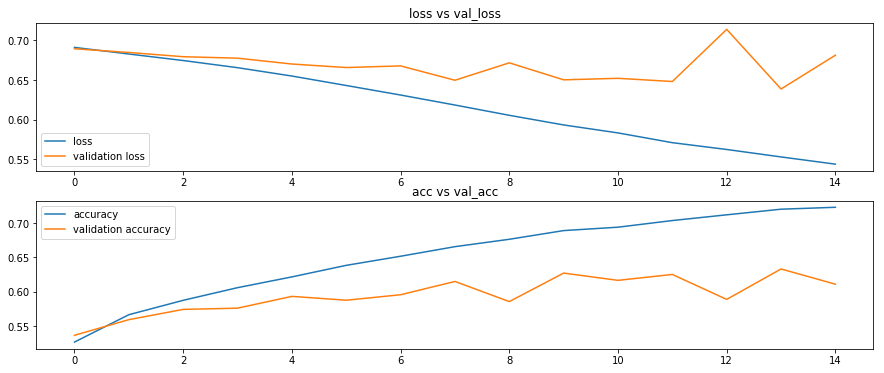

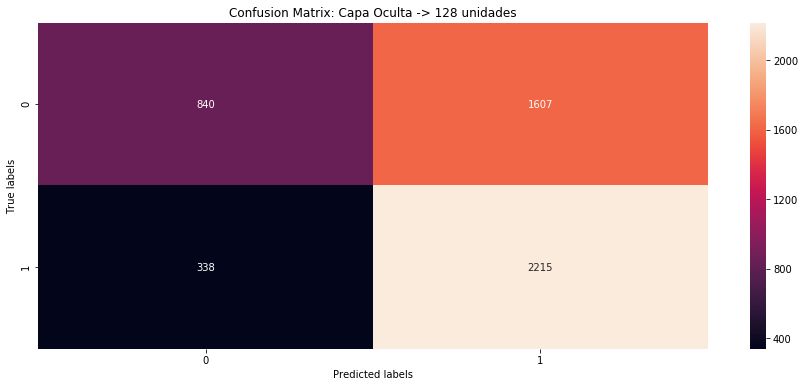

              precision    recall  f1-score   support

           0       0.71      0.34      0.46      2447
           1       0.58      0.87      0.69      2553

    accuracy                           0.61      5000
   macro avg       0.65      0.61      0.58      5000
weighted avg       0.64      0.61      0.58      5000

Red con 256 unidades
Train on 45000 samples, validate on 5000 samples
Epoch 1/15
45000/45000 [==============================] - 9s 203us/step - loss: 0.6913 - acc: 0.5260 - val_loss: 0.6882 - val_acc: 0.5360
Epoch 2/15
45000/45000 [==============================] - 9s 203us/step - loss: 0.6827 - acc: 0.5643 - val_loss: 0.6846 - val_acc: 0.5542
Epoch 3/15
45000/45000 [==============================] - 9s 192us/step - loss: 0.6753 - acc: 0.5852 - val_loss: 0.6801 - val_acc: 0.5736
Epoch 4/15
45000/45000 [==============================] - 9s 195us/step - loss: 0.6663 - acc: 0.6051 - val_loss: 0.6735 - val_acc: 0.5794
Epoch 5/15
45000/45000 [===========================

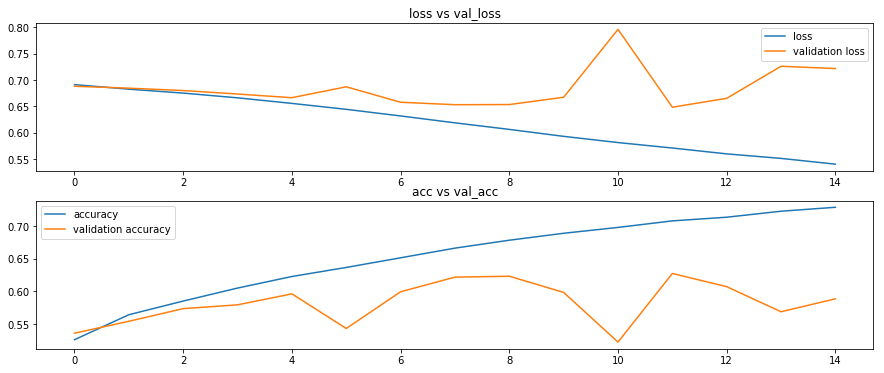

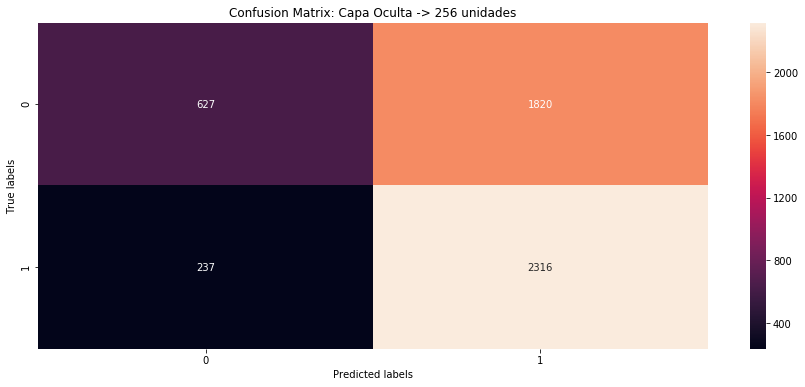

              precision    recall  f1-score   support

           0       0.73      0.26      0.38      2447
           1       0.56      0.91      0.69      2553

    accuracy                           0.59      5000
   macro avg       0.64      0.58      0.54      5000
weighted avg       0.64      0.59      0.54      5000



In [35]:
import gc
import keras.backend as K
better_acc=0
better_acc_units=None
better_val_acc=0
better_val_acc_units=None
for i in range(1,9):
    units=2**i
    print('Red con {} unidades'.format(units))
    model3d_relu = Sequential()
    model3d_relu.add(Dense(units=units, activation='relu', input_dim=x_tr.shape[1]))
    model3d_relu.add(Dense(1,activation='sigmoid'))
    model3d_relu.compile('sgd',loss='binary_crossentropy',metrics=['accuracy'])
    history3d_relu = model3d_relu.fit(x_tr,y_tr, epochs=15, validation_data=(x_val,y_val))
    max_acc=np.max(history3d_relu.history['acc'])
    if max_acc>better_acc:
        better_acc=max_acc
        better_acc_units=units
    max_acc_val=np.max(history3d_relu.history['val_acc'])
    if max_acc_val>better_val_acc:
        better_val_acc=max_acc_val
        better_val_acc_units=units
    print('Better accuracy: {} con {} unidades , better validation accuracy: {} con {} unidades'
          .format(better_acc, better_acc_units,better_val_acc,better_val_acc_units))
    showValAcc(history3d_relu)
    y_pred=model3d_relu.predict(x_val)
    y_pred_binary = np.where(y_pred>0.5, 1,0)
    plotCM(y_val, y_pred_binary, 'Capa Oculta -> {} unidades'.format(units))
    print(classification_report(y_val, y_pred_binary))
    
    del model3d_relu
    for _ in range(10):
        gc.collect()
    K.clear_session()

#### 3.e Pesos de la red

Obtenga los pesos de la red entrenada a completitud anteriormente usando el método `.get_weights` y grafíque un historgrama. Note que para cada capa se obtienen por separado los pesos de los datos y del intercepto. Así en el índice 0 obtenemos los pesos de los datos de entrada, en el 1 los pesos del intercepto de entrada, en el 2 los pesos de la capa oculta y en el 3 los pesos del intercepto de la capa oculta. Solo se requiere graficar el primero.

Compare luego ese histograma con el obtenido al graficar los pesos de una red sin entrenar, como muestra el código. Discuta lo que observa. 

In [40]:
units=128
model3e_relu_untrained = Sequential()
model3e_relu_untrained.add(Dense(units=units, activation='relu', input_dim=new_x_tr_vec.shape[1]))
model3e_relu_untrained.add(Dense(1,activation='sigmoid'))
model3e_relu_untrained.compile(SGD(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
model3e_relu_untrained.fit(new_x_tr_vec.todense(),y_tr, epochs=0, validation_data=(new_x_val_vec.todense(),y_val))

Train on 45000 samples, validate on 5000 samples


In [41]:
def plotWeights(weights):
    plt.figure(figsize=(15,6))
    plt.hist(weights)
    plt.show()

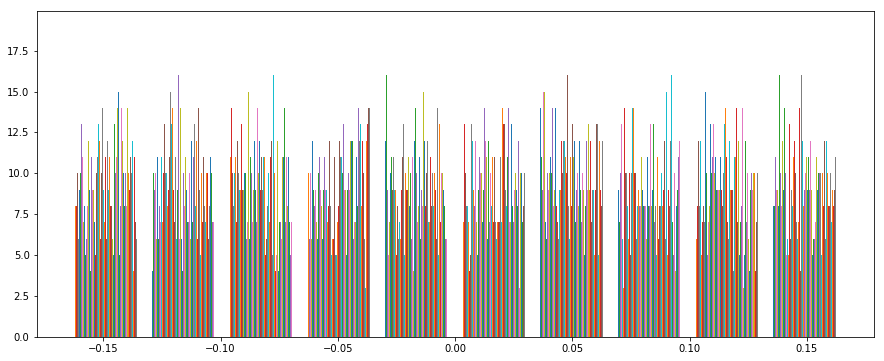

In [42]:
plotWeights(model3e_relu_untrained.get_weights()[0])

Train on 45000 samples, validate on 5000 samples
Epoch 1/15
45000/45000 [==============================] - 8s 171us/step - loss: 0.7265 - acc: 0.5364 - val_loss: 0.7279 - val_acc: 0.5392


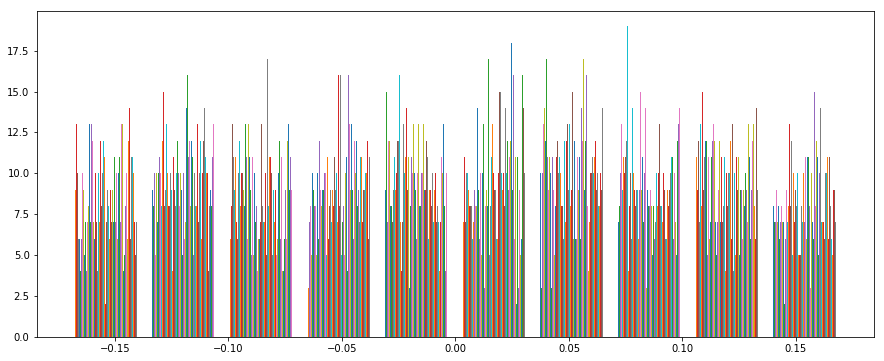

Epoch 2/15
45000/45000 [==============================] - 7s 166us/step - loss: 0.6852 - acc: 0.5712 - val_loss: 0.6646 - val_acc: 0.5938


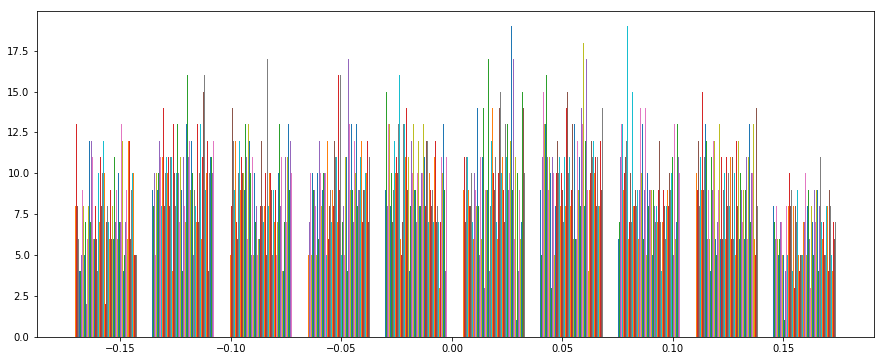

Epoch 3/15
45000/45000 [==============================] - 7s 165us/step - loss: 0.6702 - acc: 0.5906 - val_loss: 0.6503 - val_acc: 0.6166


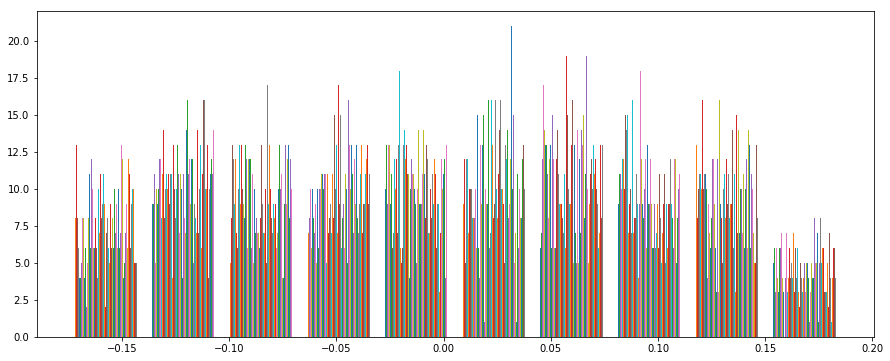

Epoch 4/15
45000/45000 [==============================] - 8s 175us/step - loss: 0.6595 - acc: 0.6046 - val_loss: 0.6647 - val_acc: 0.5794


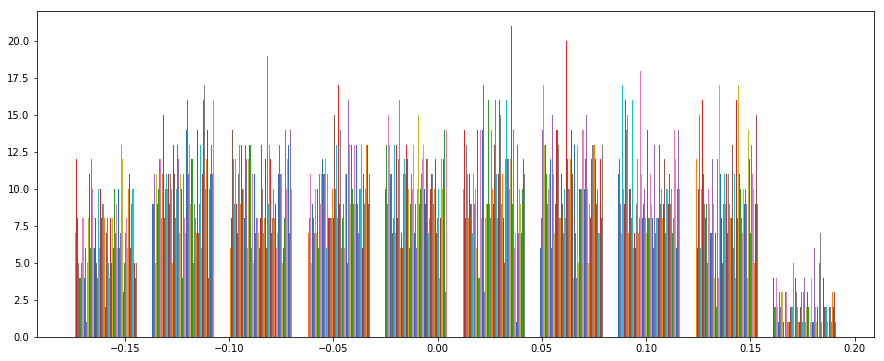

Epoch 5/15
45000/45000 [==============================] - 7s 166us/step - loss: 0.6509 - acc: 0.6132 - val_loss: 0.6805 - val_acc: 0.5850


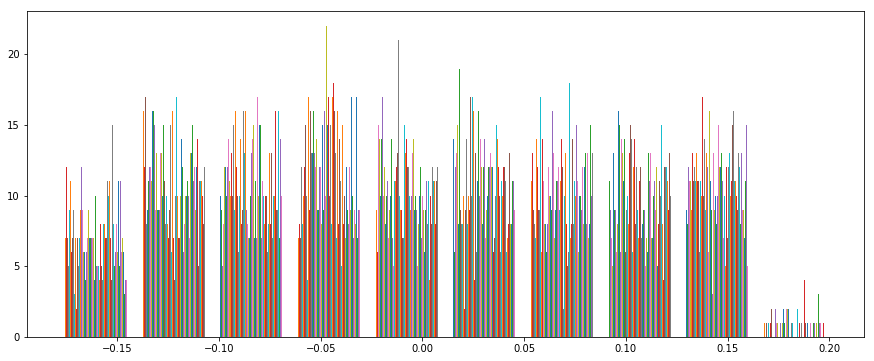

Epoch 6/15
45000/45000 [==============================] - 10s 213us/step - loss: 0.6463 - acc: 0.6198 - val_loss: 0.6409 - val_acc: 0.6220


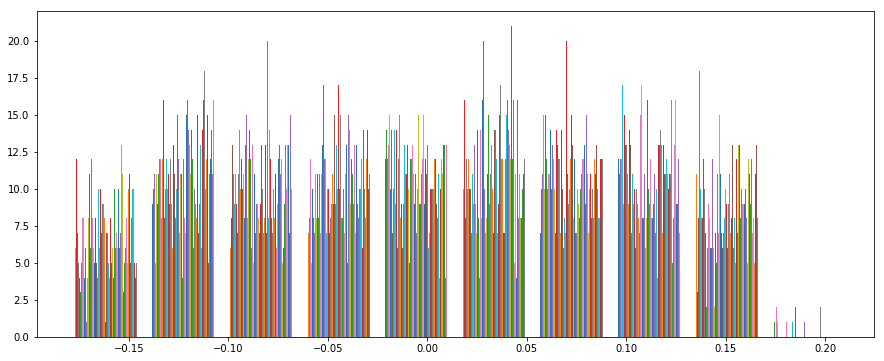

Epoch 7/15
45000/45000 [==============================] - 7s 165us/step - loss: 0.6403 - acc: 0.6278 - val_loss: 0.6380 - val_acc: 0.6260


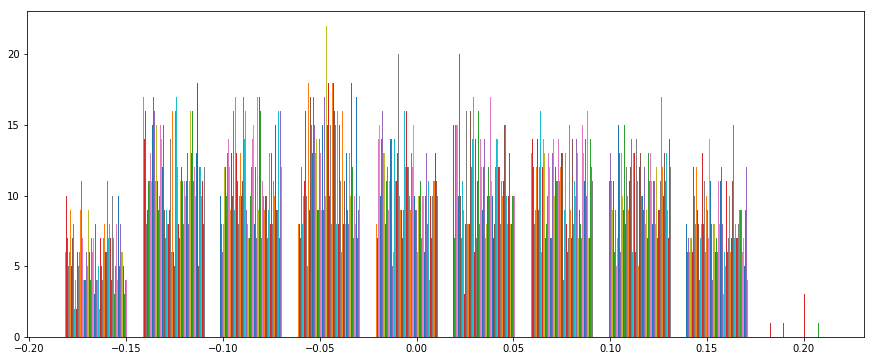

Epoch 8/15
45000/45000 [==============================] - 8s 173us/step - loss: 0.6381 - acc: 0.6320 - val_loss: 0.6221 - val_acc: 0.6544


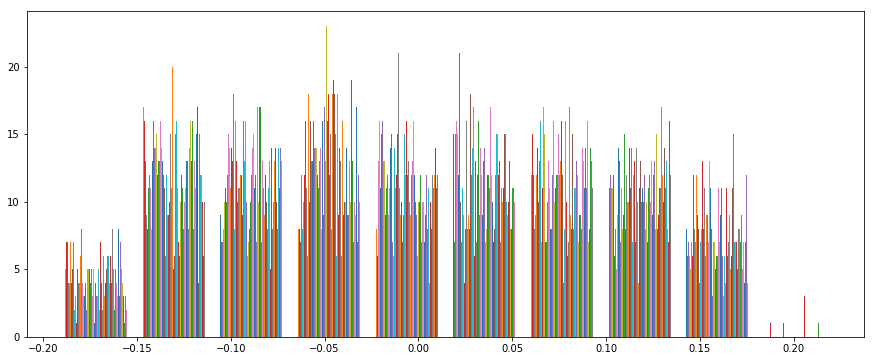

Epoch 9/15
45000/45000 [==============================] - 8s 168us/step - loss: 0.6349 - acc: 0.6333 - val_loss: 0.6299 - val_acc: 0.6402


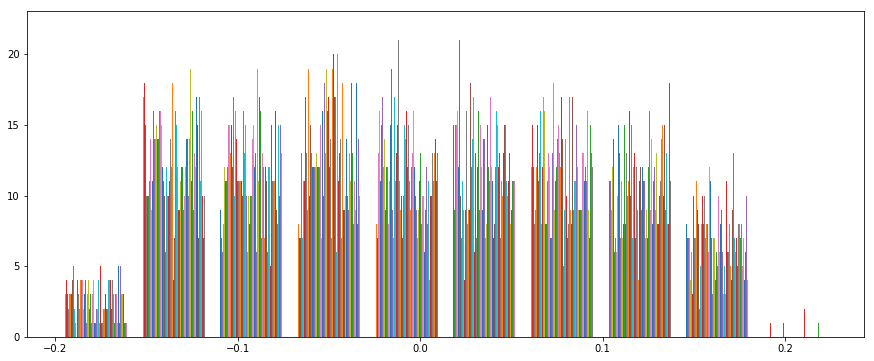

Epoch 10/15
45000/45000 [==============================] - 8s 185us/step - loss: 0.6320 - acc: 0.6374 - val_loss: 0.6190 - val_acc: 0.6544


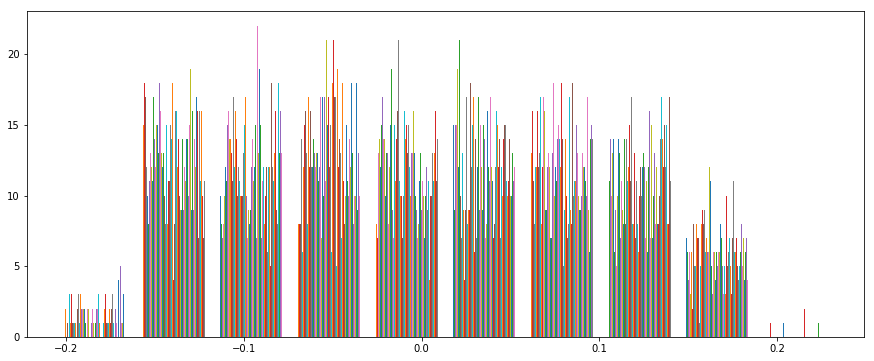

Epoch 11/15
45000/45000 [==============================] - 8s 170us/step - loss: 0.6297 - acc: 0.6405 - val_loss: 0.6692 - val_acc: 0.5810


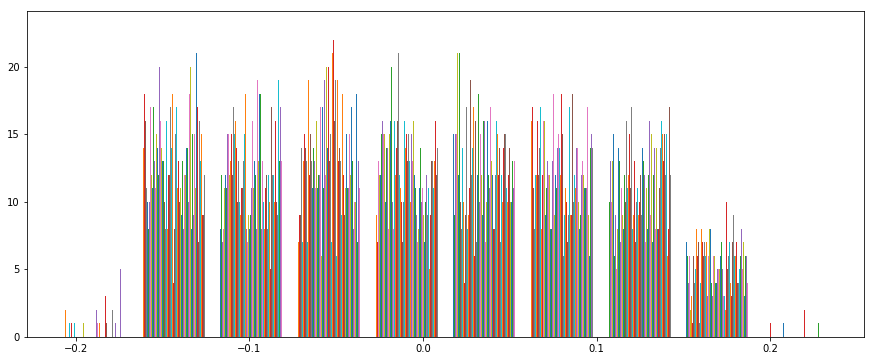

Epoch 12/15
45000/45000 [==============================] - 9s 199us/step - loss: 0.6269 - acc: 0.6454 - val_loss: 0.6158 - val_acc: 0.6570


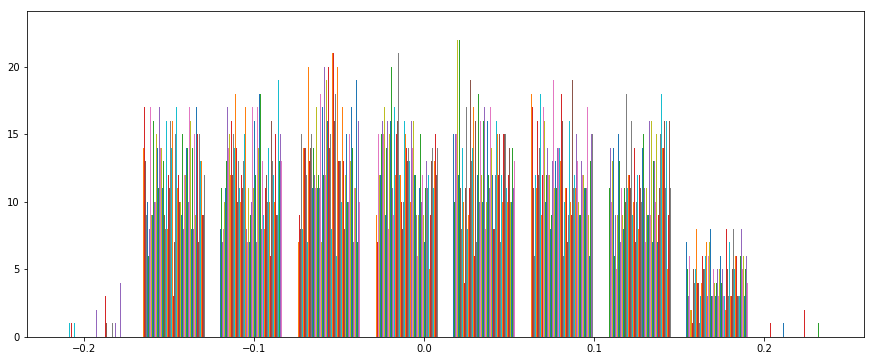

Epoch 13/15
45000/45000 [==============================] - 8s 171us/step - loss: 0.6253 - acc: 0.6444 - val_loss: 0.6360 - val_acc: 0.6188


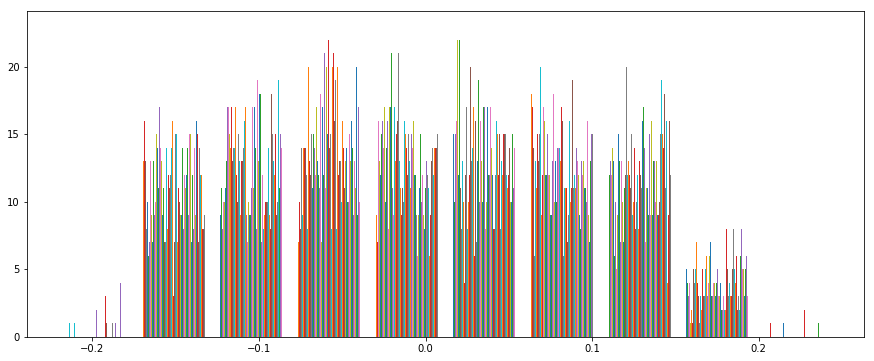

Epoch 14/15
45000/45000 [==============================] - 8s 177us/step - loss: 0.6246 - acc: 0.6446 - val_loss: 0.7686 - val_acc: 0.5250


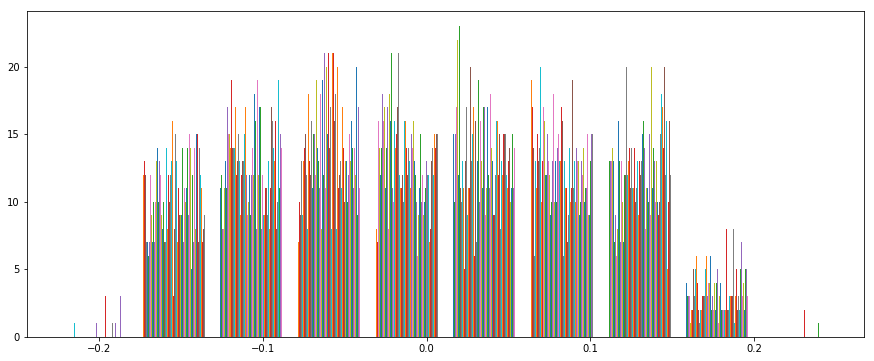

Epoch 15/15
45000/45000 [==============================] - 7s 167us/step - loss: 0.6239 - acc: 0.6467 - val_loss: 0.6258 - val_acc: 0.6388


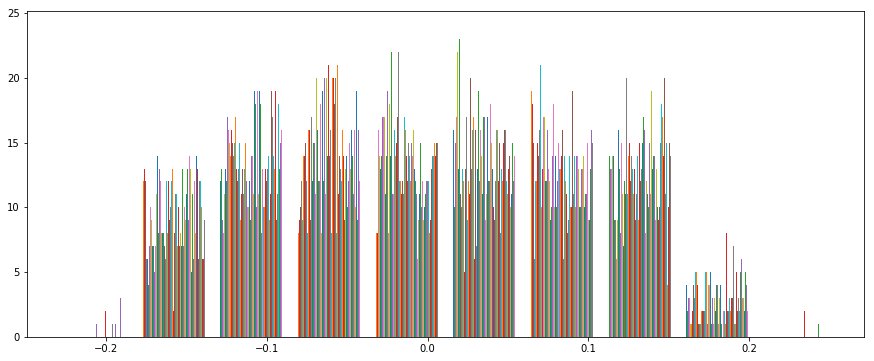

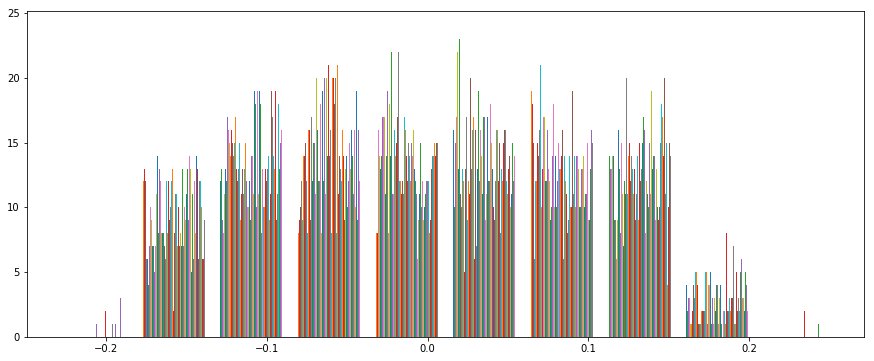

In [44]:
#units=16
model3e_relu_trained = Sequential()
model3e_relu_trained.add(Dense(units=units, activation='relu', input_dim=new_x_tr_vec.shape[1]))
model3e_relu_trained.add(Dense(1,activation='sigmoid'))
model3e_relu_trained.compile(SGD(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])

show_weights = LambdaCallback(on_epoch_end=lambda batch, 
                              logs: plotWeights(model3e_relu_trained.get_weights()[0]))


model3e_relu_trained.fit(new_x_tr_vec.todense(),y_tr, epochs=15, validation_data=(new_x_val_vec.todense(),y_val),
                        callbacks=[show_weights])
plt.figure(figsize=(15,6))
plt.hist(model3e_relu_trained.get_weights()[0])
plt.show()

#### 3.f Extreme learning Machine **(Opcional)**
En esta pregunta implementaremos una _extreme learning machine_ o ELM. Este modelo puede asimilarse a una red neuronal como la entrenada anteriormente pero donde los pesos que conectan al _input_ y la capa oculta no son entrenables. Podemos realizar esto manualmente en algunos casos o utilizando igualmente keras como muestra el código. 
Entrene una ELM y compare los tiempos de entrenamiento y desempeños obtenidos para redes con el mismo número de neuronas. Compare tambien el número de parámetros entrenables respecto redes densas del mismo tamaño. 

Pruebe un par de tamaños de red distintos, considerando la cantidad de parámetros libres de los modelos en cuestión y comente. 

In [45]:
model3f_extreme = Sequential()
model3f_extreme.add(Dense(512, activation='relu',trainable=False))
model3f_extreme.add(Dense(1,activation='sigmoid'))
model3f_extreme.compile(SGD(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
history3f_extreme=model3f_extreme.fit(new_x_tr_vec.todense(),y_tr, epochs=15, validation_data=(new_x_val_vec.todense(),y_val))

Train on 45000 samples, validate on 5000 samples
Epoch 1/15
45000/45000 [==============================] - 8s 174us/step - loss: 0.7170 - acc: 0.5086 - val_loss: 0.9272 - val_acc: 0.5110
Epoch 2/15
45000/45000 [==============================] - 7s 161us/step - loss: 0.6894 - acc: 0.5532 - val_loss: 0.9277 - val_acc: 0.4894
Epoch 3/15
45000/45000 [==============================] - 7s 162us/step - loss: 0.6768 - acc: 0.5756 - val_loss: 0.7569 - val_acc: 0.4944
Epoch 4/15
45000/45000 [==============================] - 8s 167us/step - loss: 0.6684 - acc: 0.5886 - val_loss: 0.6496 - val_acc: 0.6236
Epoch 5/15
45000/45000 [==============================] - 7s 165us/step - loss: 0.6614 - acc: 0.5999 - val_loss: 0.6677 - val_acc: 0.5928
Epoch 6/15
45000/45000 [==============================] - 8s 170us/step - loss: 0.6577 - acc: 0.6053 - val_loss: 0.6800 - val_acc: 0.5844
Epoch 7/15
45000/45000 [==============================] - 7s 159us/step - loss: 0.6524 - acc: 0.6127 - val_loss: 0.6702 - v

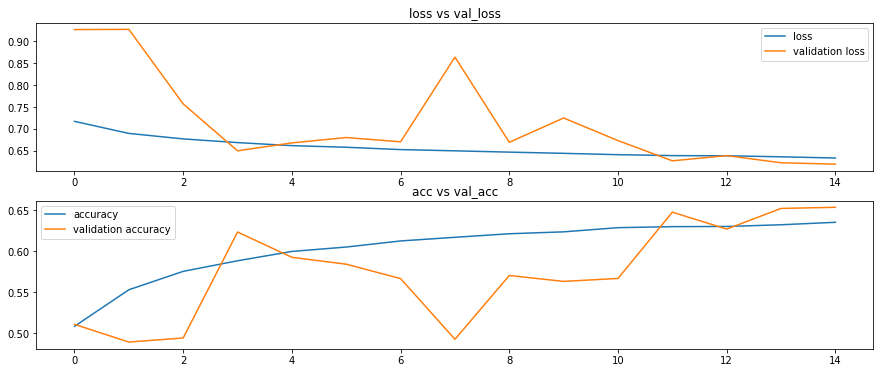

In [46]:
showValAcc(history3f_extreme)

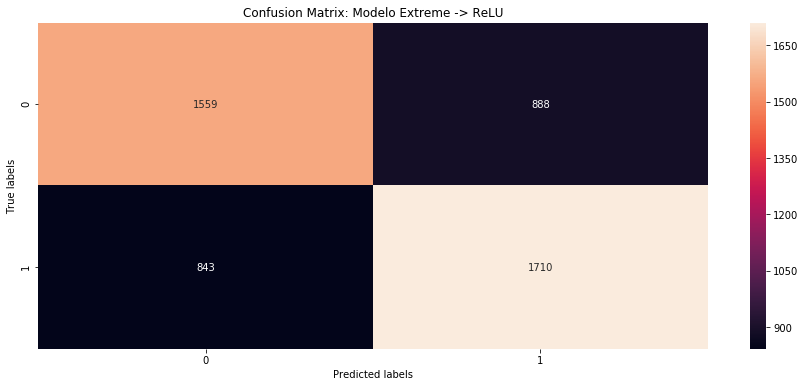

              precision    recall  f1-score   support

           0       0.65      0.64      0.64      2447
           1       0.66      0.67      0.66      2553

    accuracy                           0.65      5000
   macro avg       0.65      0.65      0.65      5000
weighted avg       0.65      0.65      0.65      5000



In [47]:
y_pred=model3f_extreme.predict(new_x_val_vec.todense())
y_pred_binary = np.where(y_pred>0.5, 1,0)
plotCM(y_val, y_pred_binary, 'Modelo Extreme -> ReLU')
print(classification_report(y_val, y_pred_binary))

#### 3.g Autoencoders  **(Opcional)**
Otra aproximación muy ingeniosa para mejorar el desempeño de algunos modelos es el uso de _autoenconders_. Comente brevemente sobre qué realizar un _autoencoder_ y sobre por qué no necesita conocer el target para entrenarse.

Esta característica de los _autoencoders_ han permitido mejorar drásticamente muchas aplicaciones reales donde se tienen enormes cantidades de datos sin _target_ y menos datos ya etiquetados (por ejemplo, en reconocimiento de imagenes google tiene acceso a una cantidad en la práctica ilimitada de fotos de sus usuarios pero muy pocas fotos "etiquetadas" en comparación), aprendiendo representaciones relevantes de los datos y luego transfiriendo ese conocimiento. En esta pregunta utilizaremos un autoencoder para tratar de mejorar el desempeño de la red neuronal densa. 

Para esto primero entrenaremos una red neuronal densa que tiene como _input_ y _target_ nuestros `x_tr`. Una vez entrenada esa red, extraeremos sus pesos de la capa escondida para obtener nuestra capa _encoder_ y nuestra capa _decoder_. Finalmente, utilizaremos nuestra capa de _encoding_ como la primera capa de un nuevo modelo (más pequeño), el cual luego entrenaremos sin modificar los pesos de la capa _encoding_.

Note que este procedimiento también puede hacerse como un preprocesamiento de los datos, sin embargo les propongo esta manera pues pone en evidencia el proceso de _transfer learning_ que comentabamos anteriormente. 

In [56]:
model3g_autoencoder = Sequential()
model3g_autoencoder.add(Dense(128, activation='relu')) # you can change the number of units
model3g_autoencoder.add(Dense(new_x_tr_vec.todense().shape[1]))
model3g_autoencoder.compile(SGD(lr=0.00005),loss='categorical_crossentropy',metrics=['accuracy'])
model3g_autoencoder.fit(new_x_tr_vec.todense(),new_x_tr_vec.todense(), epochs=3, validation_data=(new_x_val_vec.todense(),new_x_val_vec.todense()))

Train on 45000 samples, validate on 5000 samples
Epoch 1/3
45000/45000 [==============================] - 9s 189us/step - loss: 597.2508 - acc: 0.9332 - val_loss: 501.4831 - val_acc: 1.0000
Epoch 2/3
45000/45000 [==============================] - 8s 173us/step - loss: 497.5783 - acc: 1.0000 - val_loss: 525.6426 - val_acc: 1.0000
Epoch 3/3
45000/45000 [==============================] - 8s 175us/step - loss: 478.8566 - acc: 1.0000 - val_loss: 416.4788 - val_acc: 1.0000


In [57]:
encoder3g = model3g_autoencoder.layers[0]
decoder3g = model3g_autoencoder.layers[1]

In [58]:
#create the new model
model3g = Sequential()
model3g.add(encoder3g)
model3g.layers[0].trainable = False 
model3g.add(Dense(128, activation='relu')) # you can change the number of units
model3g.add(Dense(1, activation='sigmoid'))
model3g.compile(SGD(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
model3g.fit(new_x_tr_vec.todense(),y_tr, epochs=15, validation_data=(new_x_val_vec.todense(),y_val))
# we dont want to train the encoder
# add the hidden and output layers

# compile and fit

Train on 45000 samples, validate on 5000 samples
Epoch 1/15
45000/45000 [==============================] - 8s 180us/step - loss: 0.7261 - acc: 0.5297 - val_loss: 0.7799 - val_acc: 0.5156
Epoch 2/15
45000/45000 [==============================] - 8s 168us/step - loss: 0.6986 - acc: 0.5496 - val_loss: 0.7371 - val_acc: 0.4948
Epoch 3/15
45000/45000 [==============================] - 8s 174us/step - loss: 0.6858 - acc: 0.5669 - val_loss: 1.0359 - val_acc: 0.4894
Epoch 4/15
45000/45000 [==============================] - 8s 171us/step - loss: 0.6800 - acc: 0.5753 - val_loss: 0.6578 - val_acc: 0.6114
Epoch 5/15
45000/45000 [==============================] - 8s 176us/step - loss: 0.6767 - acc: 0.5771 - val_loss: 0.7440 - val_acc: 0.5346
Epoch 6/15
45000/45000 [==============================] - 10s 220us/step - loss: 0.6725 - acc: 0.5821 - val_loss: 0.6954 - val_acc: 0.5624
Epoch 7/15
45000/45000 [==============================] - 10s 216us/step - loss: 0.6692 - acc: 0.5897 - val_loss: 0.8278 -

In [59]:
model3g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 128)               11776     
_________________________________________________________________
dense_29 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 129       
Total params: 28,417
Trainable params: 16,641
Non-trainable params: 11,776
_________________________________________________________________


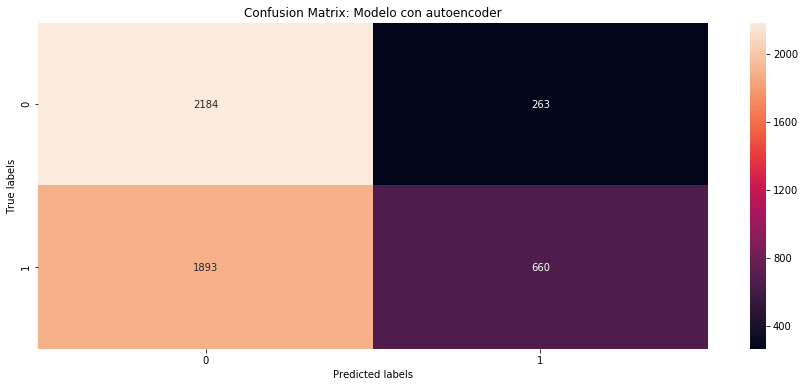

              precision    recall  f1-score   support

           0       0.54      0.89      0.67      2447
           1       0.72      0.26      0.38      2553

    accuracy                           0.57      5000
   macro avg       0.63      0.58      0.52      5000
weighted avg       0.63      0.57      0.52      5000



In [60]:
y_pred=model3g.predict(new_x_val_vec.todense())
y_pred_binary = np.where(y_pred>0.5, 1,0)
plotCM(y_val, y_pred_binary, 'Modelo con autoencoder')
print(classification_report(y_val, y_pred_binary))

#### 3.h Árbol

Utilizemos ahora un arbol de clasificación para tratar de resolver el problema. Para este modelo es recomendable usar los datos originales (antes de utilizar la función `to_categorical`), si bien el modelo podrá ajustarse y encontrará desempeños parecidos, el tiempo de cómputo será mucho mayor con los datos categóricos.

Luego de entrenar el árbol, calcule su _accuracy_ y compare el desempeño con las redes entrenadas anteriormente. 

In [61]:
tree3h = DecisionTreeClassifier(max_depth=45) #or another depth 
tree3h.fit(new_x_tr_vec.todense(),y_tr)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=45,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

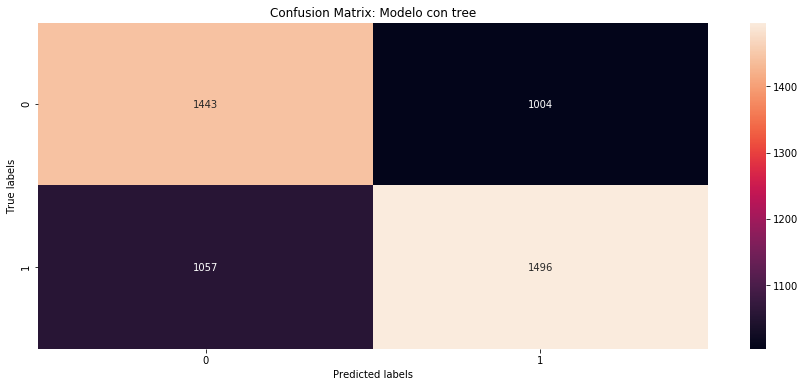

              precision    recall  f1-score   support

           0       0.54      0.89      0.67      2447
           1       0.72      0.26      0.38      2553

    accuracy                           0.57      5000
   macro avg       0.63      0.58      0.52      5000
weighted avg       0.63      0.57      0.52      5000



In [62]:
y_pred=tree3h.predict(new_x_val_vec.todense())
plotCM(y_val, y_pred, 'Modelo con tree')
print(classification_report(y_val, y_pred_binary))

#### 3.i Bagging **(Opcional)**

Crearemos ahora un ensamblado utilizando la técnica de _Bagging_, ensamblando las predicciones de distintos árboles para predecir el resultado. 

Explique brevemente el procedimiento realizado por _Bagging_, en particular por qué los distintos arboles no se entrenan idénticamente y el significado de los parámetros que aparecen en el código. 

In [63]:
bag3i = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                        n_estimators=100,
                        max_samples=0.5,
                        max_features=0.7
                       )

In [65]:
model3i=bag3i.fit(new_x_tr_vec.todense(), y_tr)

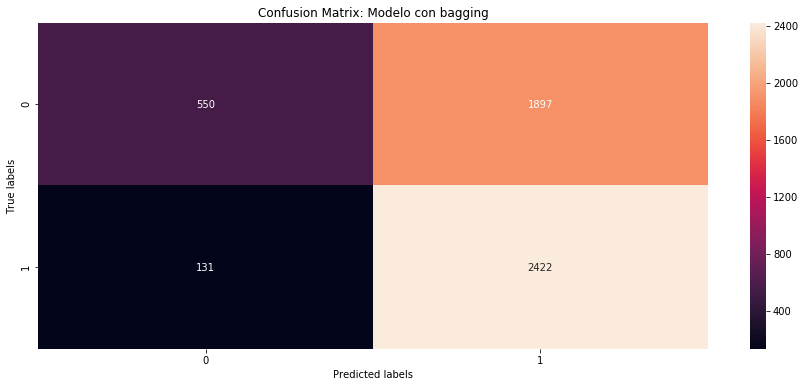

              precision    recall  f1-score   support

           0       0.54      0.89      0.67      2447
           1       0.72      0.26      0.38      2553

    accuracy                           0.57      5000
   macro avg       0.63      0.58      0.52      5000
weighted avg       0.63      0.57      0.52      5000



In [66]:
y_pred=model3i.predict(new_x_val_vec.todense())
plotCM(y_val, y_pred, 'Modelo con bagging')
print(classification_report(y_val, y_pred_binary))

#### 3.j AdaBoost
_Adaptative Boosting_ o AdaBoost es otro meta-algoritmo que crea ensamblados a partir de modelos más simple. Entrene un modelo de AdaBoost con estimado base un árbol de baja profundidad (menor a 20) y un límite de estimadores (`n_estimators`) de a lo menos 50. 

Calcule su _accuracy_ y comparelo con los demás métodos. 

In [69]:
ada3j = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                        n_estimators=100,
                       )

In [70]:
model3j=ada3j.fit(new_x_tr_vec.todense(), y_tr)

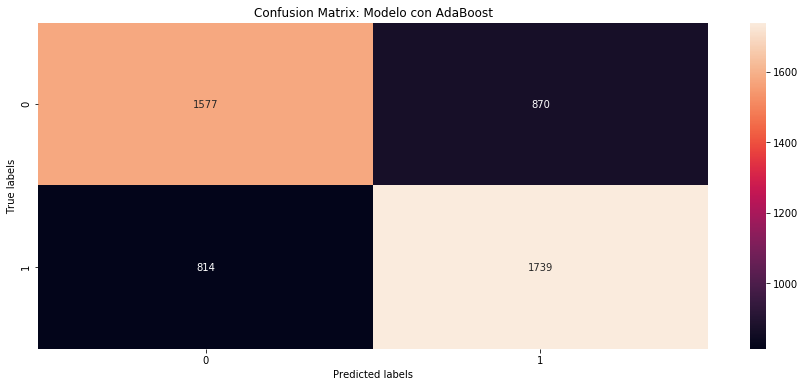

              precision    recall  f1-score   support

           0       0.66      0.64      0.65      2447
           1       0.67      0.68      0.67      2553

    accuracy                           0.66      5000
   macro avg       0.66      0.66      0.66      5000
weighted avg       0.66      0.66      0.66      5000



In [71]:
y_pred=model3j.predict(new_x_val_vec.todense())
plotCM(y_val, y_pred, 'Modelo con AdaBoost')
print(classification_report(y_val, y_pred))